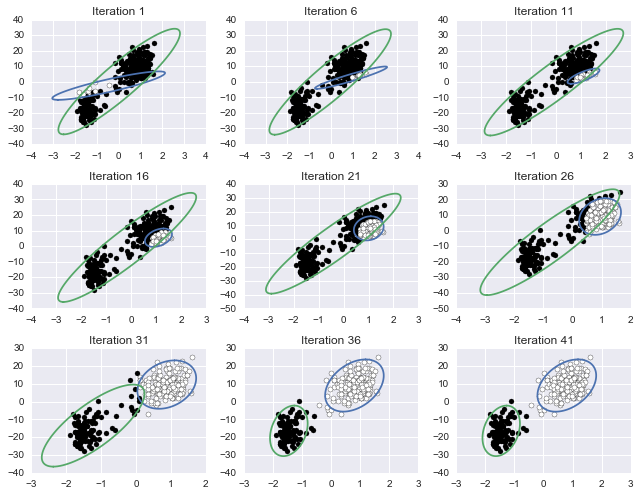

In [18]:
import numpy as np
from scipy import io
from matplotlib import pyplot as plt
import seaborn
from scipy import linalg as la
from scipy.stats import multivariate_normal
%matplotlib inline

# Load in the data
data = io.loadmat('old_faithful.mat')['data']

# Mean-Center the data
data -= np.mean(data,axis=0)

# Initialize Gaussian means (accessed as column vectors, e.g. [:,k])
mu = np.array([[-1.17288986, -0.11642103], [-0.16526981,  0.70142713]])

# Initialize Gaussian covariance matrices (access as cov[k,:,:])
cov = np.array([np.array([[0.74072815, 0.09252716], [0.09252716, 0.5966275]]),
        np.array([[0.39312776,-0.46488887], [-0.46488887,1.64990767]])])

# Initialize Gaussian mixing weights (access as alpha[k])
alpha = np.array([0.68618439, 0.31381561]) 

# Get number of kernels and number of points
K = 2
N = data.shape[0]

# Initialize responsibility array (access as w[:,k] or w[i,k])
w = np.zeros((N,2))

# Helper function for ellipse
def cov_to_pts(cov):
    circ = np.linspace(0, 2*np.pi, 100)
    sf = np.array([np.cos(circ), np.sin(circ)])
    
    U, S, V = la.svd(cov)
    pmat = U*2.447*np.sqrt(S) # 95% confidence
    return np.dot(pmat, sf)

# EM Algorithm
for j in xrange(41):
    
    # Estimate responsibilities
    for k in xrange(K):
        w[:,k] = multivariate_normal.pdf(data, mu[:,k], cov[k,:,:])*alpha[k]
    w = (w.T/np.sum(w,axis=1)).T
    
    # Estimate effective number of points
    Nk = np.sum(w,axis=0)
    
    # Estimate mixing weights
    alpha = Nk/N
    
    # Estimate means
    for k in xrange(K):
        mu[:,k] = np.sum(w[:,k].T*data.T,axis=1).T/Nk[k]
    
    # Estimate covariances
    for k in xrange(K):
        diff = data - mu[:,k]
        # Extra transposing for numpy wizardly purposes
        cov[k,:,:] = np.dot(diff.T,(diff.T*w[:,k].T).T)/Nk[k]
    
    # Make the plot  
    if j % 5 == 0: # no need to plot EVERY iteration
        
        # Adjust the figure size and initialize subplot
        fig_size = plt.rcParams["figure.figsize"] 
        fig_size = 9, 7
        plt.rcParams["figure.figsize"] = fig_size 
        plt.subplot(3,3,j/5+1)
        
        # Determine which points belong to which kernel
        round_w = np.rint(w[:,0])
        mask = np.where(round_w == 0.0)
        mask1 = np.where(round_w == 1.0)
        
        # Plot points and circle for first kernel
        circ = cov_to_pts(cov[0,:,:].T)
        plt.scatter(data[mask,0],data[mask,1],c='black',s=25)
        plt.plot(circ[0,:] + mu[0,0],circ[1,:] + mu[1,0])

        # Plot points and circle for second kernel
        circ = cov_to_pts(cov[1,:,:].T)
        plt.scatter(data[mask1,0],data[mask1,1],c='white',s=25)
        plt.plot(circ[0,:] + mu[0,1],circ[1,:] + mu[1,1])
        
        plt.title('Iteration %s'%(j+1))
        
plt.tight_layout()
plt.show()